In [1]:
PROTOCOL="MSDWILD.SpeakerDiarization.OriginalMany"
PROTOCOL_SUBSET='test'

PYDB_PATH = "/home/aplaquet/work58/databases/msdwild/database.yml"

In [2]:
import pandas as pd
from pathlib import Path
from powerset_calibration.inference import get_inference_fid, get_inf_metadata_filename

fid = get_inference_fid('segmentation', PROTOCOL, PROTOCOL_SUBSET)
fid_path = Path('outputs')/fid

In [3]:
from pyannote.database import registry

registry.load_database(PYDB_PATH)

`ActiveLearningProtocolSettings` types the dictionaries that configure our ActiveLearningProtocol. Please see its docstrings for more details.

You don't have to provide all settings, sane values will be used for missing keys. But please specify `inference`, `scope`, `window_duration`, `annotated_duration` or ratio, and `heuristic`,

In [10]:
from powerset_calibration.protocol import ActiveLearningProtocol, ActiveLearningProtocolSettings


al_settings: ActiveLearningProtocolSettings = {
    'inference': fid_path,
    'scope': 'dataset',         # below constraints apply to the whole dataset rather than each file
    'window_duration': 10.0,    # selected regions should be at least 10 seconds long
    'sliding_window_step': 0.5, # search regions with a precision of 0.5 seconds
    'annotated_ratio': 0.5, # 30 seconds should be selected
    'heuristic': 'confidence',  # select the region with the lowest **confidence**
    'heuristic_direction': 'worst', # select the region with the **lowest** confidence
    'aggregation': 'soft_segmentation',
} # type: ignore

Found 177 URIs for subsets ('test',)
Generating active learning windows from 1687485 samples


Now let's load both the untouched protocol and the new altered protocol.

What `ActiveLearningProtocol` does is simply edit the `'annotated'` key of all files of the protocol so that the contained timeline describes the regions selected by the algorithm according to the parameters/settings that were passed.

In [ ]:
original_protocol = registry.get_protocol(PROTOCOL)
protocol = ActiveLearningProtocol(
    protocol=PROTOCOL,
    settings={
        ('test',) : al_settings
    },
    uem_save_path=Path('outputs') / 'selected_regions.uem',
)

Let's look at some UEM to see if they were edited (of course they were)

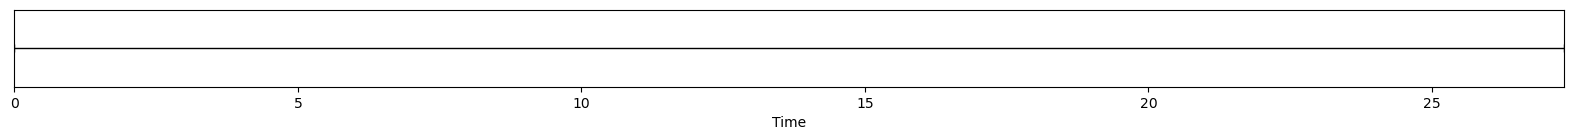

In [14]:
from pyannote.core import notebook
og_uem = next(original_protocol.test())['annotated']
notebook.crop = og_uem.extent()
og_uem

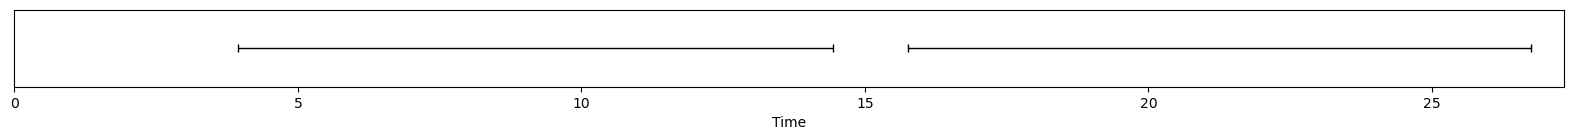

In [15]:
next(protocol.test())['annotated']

In [20]:
total_dur_og = 0.0
for file in original_protocol.test():
    total_dur_og += file['annotated'].duration()

total_dur_new = 0.0
for file in protocol.test():
    total_dur_new += file['annotated'].duration()

print(f'Total UEM duration in:\n- original protocol: {total_dur_og:.1f}s\n- new protocol: {total_dur_new:.1f}s ({total_dur_new/total_dur_og*100:.2f}%)')

Total UEM duration in:
- original protocol: 14656.6s
- new protocol: 7329.2s (50.01%)


That's it ! You can then use this protocol as usual in tasks / for evaluation / etc.
If you want to add new heuristics / strategies, I strongly recommend cloning this repository and extending the code. But I also provide a quick rundown of what happens in the ActiveLearningProtocol in the [notebook #3](3_advanced_use.ipynb) if you want more information.